In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/training')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import logging
import torch
import pickle
import pandas as pd
import matplotlib.pylab as pylab
from torch.utils.data import Dataset, Subset, DataLoader
from time import time

from pytorch.job_runners.abc_parameterizations.abc_runner import ABCRunner
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.results import *
from pytorch.configs.model import ModelConfig
from utils.nn import squared_trace_rank, frob_spec_rank

## Set variables

In [6]:
L = 6
WIDTH = 1024
BASE_LR = 0.01
BATCH_SIZE = 512
BIAS = False
N_TRIALS = 5
N_WARMUP_STEPS = 1
MODEL_NAME = 'fc_muP' # 'fc_ipllr', 'standard_fc_ip', 'fc_muP'
DATASET = 'mnist'  # 'mnist', 'cifar10'
SEED = 42

CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations')
EXPERIMENTS_DIR = 'experiments'
MODEL_NAME = 'fc_ipllr'
CONFIG_FILE = 'fc_ipllr.yaml'

FONTSIZE = 12
FIGSIZE = (10, 6)

ACT_KEY_TO_NAME = {'relu': 'ReLU',
                   'gelu': 'GeLU',
                   'elu': 'ELU',
                   'tanh': 'tanh'}


set_random_seeds(SEED)
experiments_dir = os.path.join(ROOT, 'experiments')
base_experiment = '{}_{}'.format(MODEL_NAME, DATASET)
fig_dir = os.path.join(ROOT, FIGURES_DIR, DATASET)

params = {'legend.fontsize': FONTSIZE,
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE}
pylab.rcParams.update(params)

## Data and config

In [7]:
base_lr = BASE_LR
batch_size = BATCH_SIZE
dataset = DATASET
download = False

model_name = '{}_{}'.format(MODEL_NAME, dataset)
config_path = os.path.join(CONFIG_PATH, '{}.yaml'.format(model_name))
config_dict = read_yaml(config_path)

# define corresponding directory in experiments folder
base_experiment_path = os.path.join(ROOT, EXPERIMENTS_DIR, model_name)  # base experiment folder

# Load data & define models
logger = logging.getLogger()
logger.info('Loading data ...')
if dataset == 'mnist':
    from utils.dataset.mnist import load_data
elif dataset == 'cifar10':
    from utils.dataset.cifar10 import load_data
elif dataset == 'cifar100':
    # TODO : add cifar100 to utils.dataset
    pass
else:
    error = ValueError("dataset must be one of ['mnist', 'cifar10', 'cifar100'] but was {}".format(dataset))
    logger.error(error)
    raise error

# prepare data
training_dataset, _ = load_data(download=download, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=BATCH_SIZE)

batches = list(train_data_loader)

In [8]:
config_dict['architecture']['width'] = WIDTH
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = BASE_LR
config_dict['training']['batch_size'] = BATCH_SIZE
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': N_WARMUP_STEPS,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}

In [9]:
models = dict()
for activation in ACT_KEY_TO_NAME.keys():
    config_dict['activation']['name'] = activation
    config = ModelConfig(config_dict=config_dict)
    models[activation] = [FcIPLLR(config, lr_calibration_batches=batches[:2], 
                                  n_warmup_steps=N_WARMUP_STEPS) for _ in range(N_TRIALS)]

In [10]:
full_x = torch.cat([a for a,_ in batches], dim=0)
full_y = torch.cat([b for _,b in batches], dim=0)
print(full_x.size(), full_y.size())

torch.Size([60000, 784]) torch.Size([60000])


## Train models for one step

In [11]:
x, y = batches[0]
for activation in models.keys():
    for model in models[activation]:
        model.train()
        y_hat = model.forward(x)
        loss = model.loss(y_hat, y)
        loss.backward()
        model.optimizer.step()
        if hasattr(model, "scheduler") and model.scheduler is not None:
            model.scheduler.step()
        model.eval()

## Compute ranks on a large batch fro IP-LLR at time $t=1$

In [12]:
n_samples = 5000
x_b = full_x[:n_samples, :]
y_b = full_y[:n_samples]

In [13]:
torch_rank_hs = dict()
torch_rank_xs = dict()

trace_rank_hs = dict()
trace_rank_xs = dict()

frob_rank_hs = dict()
frob_rank_xs = dict()

In [18]:
start = time()
with torch.no_grad():
    for activation in models.keys():
        torch_rank_hs_ = []
        torch_rank_xs_ = []
        
        trace_rank_hs_ = []
        trace_rank_xs_ = []
        
        frob_rank_hs_ = []
        frob_rank_xs_ = []
        
        for model in models[activation]:
            x = x_b
            model.eval()
            
            torch_rank_model_hs = dict()
            torch_rank_model_xs = {'0': torch.matrix_rank(x).item()}
            
            #trace_rank_model_hs = dict()
            #trace_rank_model_xs = {'0': squared_trace_rank(x)}
            
            #frob_rank_model_hs = dict()
            #frob_rank_model_xs = {'0': frob_spec_rank(x)}
            
            h = (model.width ** (-model.a[0])) * model.input_layer.forward(x)
            x = model.activation(h)
            
            torch_rank_model_hs['1'] = torch.matrix_rank(h).item()
            torch_rank_model_xs['1'] = torch.matrix_rank(x).item()
            
            #trace_rank_model_hs['1'] = squared_trace_rank(h)
            #trace_rank_model_xs['1'] = squared_trace_rank(x)
            
            #frob_rank_model_hs['1'] = frob_spec_rank(h)
            #frob_rank_model_xs['1'] = frob_spec_rank(x)
            
            for l, layer in enumerate(model.intermediate_layers):  
                h = (model.width ** (-model.a[l+1])) * layer.forward(x)  
                x = model.activation(h)
                
                torch_rank_model_hs[str(l+2)] = torch.matrix_rank(h).item()
                torch_rank_model_xs[str(l+2)] = torch.matrix_rank(x).item()
            
            h = (model.width ** (-model.a[model.n_layers-1])) * model.output_layer.forward(x)
            y_hat = model.forward(x_b)
            torch.testing.assert_allclose(h, y_hat, atol=1e-3, rtol=1e-4)
                #trace_rank_model_hs[str(l+2)] = squared_trace_rank(h)
                #trace_rank_model_xs[str(l+2)] = squared_trace_rank(x)
                
                #frob_rank_model_hs[str(l+2)] = frob_spec_rank(h)
                #frob_rank_model_xs[str(l+2)] = frob_spec_rank(x)


            torch_rank_hs_.append(torch_rank_model_hs)
            torch_rank_xs_.append(torch_rank_model_xs)
            
            #trace_rank_hs_.append(trace_rank_model_hs)
            #trace_rank_xs_.append(trace_rank_model_xs)
            
            #frob_rank_hs_.append(frob_rank_model_hs)
            #frob_rank_xs_.append(frob_rank_model_xs)

        torch_rank_hs[activation] = torch_rank_hs_
        torch_rank_xs[activation] = torch_rank_xs_
        
        #trace_rank_hs[activation] = trace_rank_hs_
        #trace_rank_xs[activation] = trace_rank_xs_
        
        #frob_rank_hs[activation] = frob_rank_hs_
        #frob_rank_xs[activation] = frob_rank_xs_
end = time()
print('Time for computing all ranks on full training set: {:.2f} minutes'.format((end - start) / 60))

Time for computing all ranks on full training set: 3.06 minutes


In [19]:
torch_rank_hs

{'relu': [{'1': 592, '2': 145, '3': 9, '4': 2, '5': 1, '6': 1},
  {'1': 593, '2': 144, '3': 9, '4': 1, '5': 1, '6': 1},
  {'1': 593, '2': 151, '3': 10, '4': 3, '5': 1, '6': 1},
  {'1': 594, '2': 145, '3': 9, '4': 3, '5': 1, '6': 1},
  {'1': 594, '2': 147, '3': 9, '4': 3, '5': 1, '6': 1}],
 'gelu': [{'1': 593, '2': 385, '3': 11, '4': 10, '5': 10, '6': 9},
  {'1': 591, '2': 386, '3': 12, '4': 9, '5': 10, '6': 9},
  {'1': 592, '2': 384, '3': 12, '4': 9, '5': 9, '6': 7},
  {'1': 595, '2': 389, '3': 12, '4': 10, '5': 9, '6': 10},
  {'1': 594, '2': 394, '3': 14, '4': 10, '5': 9, '6': 9}],
 'elu': [{'1': 592, '2': 88, '3': 11, '4': 11, '5': 10, '6': 10},
  {'1': 592, '2': 86, '3': 11, '4': 9, '5': 9, '6': 9},
  {'1': 593, '2': 87, '3': 12, '4': 9, '5': 9, '6': 8},
  {'1': 591, '2': 86, '3': 11, '4': 9, '5': 9, '6': 8},
  {'1': 591, '2': 87, '3': 12, '4': 11, '5': 9, '6': 9}],
 'tanh': [{'1': 595, '2': 58, '3': 13, '4': 18, '5': 17, '6': 17},
  {'1': 593, '2': 60, '3': 12, '4': 14, '5': 12, '6

In [20]:
torch_rank_xs

{'relu': [{'0': 638, '1': 982, '2': 162, '3': 9, '4': 2, '5': 1, '6': 1},
  {'0': 638, '1': 989, '2': 160, '3': 9, '4': 1, '5': 1, '6': 1},
  {'0': 638, '1': 993, '2': 175, '3': 10, '4': 3, '5': 1, '6': 1},
  {'0': 638, '1': 996, '2': 170, '3': 9, '4': 3, '5': 1, '6': 1},
  {'0': 638, '1': 988, '2': 173, '3': 9, '4': 3, '5': 1, '6': 1}],
 'gelu': [{'0': 638, '1': 998, '2': 382, '3': 32, '4': 28, '5': 22, '6': 16},
  {'0': 638, '1': 994, '2': 386, '3': 29, '4': 26, '5': 21, '6': 22},
  {'0': 638, '1': 1001, '2': 374, '3': 24, '4': 15, '5': 13, '6': 10},
  {'0': 638, '1': 999, '2': 385, '3': 28, '4': 25, '5': 21, '6': 32},
  {'0': 638, '1': 999, '2': 404, '3': 33, '4': 21, '5': 16, '6': 14}],
 'elu': [{'0': 638, '1': 1022, '2': 148, '3': 66, '4': 50, '5': 37, '6': 47},
  {'0': 638, '1': 1023, '2': 140, '3': 33, '4': 34, '5': 27, '6': 25},
  {'0': 638, '1': 1022, '2': 153, '3': 35, '4': 20, '5': 16, '6': 12},
  {'0': 638, '1': 1020, '2': 139, '3': 30, '4': 20, '5': 14, '6': 11},
  {'0': 6

In [28]:
ranks_df = pd.DataFrame(columns=['layer', 'rank', 'type', 'activation'])

In [45]:
idx = 0
for i in range(N_TRIALS):
    for activation in torch_rank_hs.keys():
        h_ranks = torch_rank_hs[activation][i]
        x_ranks = torch_rank_xs[activation][i]
        for l in range(1, L+1):
            ranks_df.loc[idx, ['layer', 'rank', 'type', 'activation']] = \
                [l, h_ranks[str(l)], '$h^l_1$', ACT_KEY_TO_NAME[activation]]
            ranks_df.loc[idx+1, ['layer', 'rank', 'type', 'activation']] = \
                [l, x_ranks[str(l)], '$x^l_1$', ACT_KEY_TO_NAME[activation]]
            idx += 2

In [46]:
ranks_df.loc[:, 'rank'] = ranks_df.loc[:, 'rank'].astype(float)

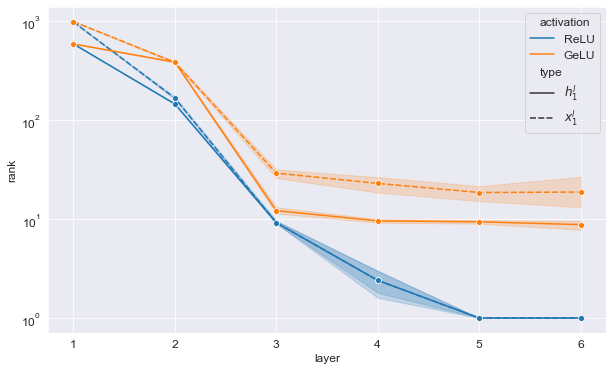

In [48]:
df = ranks_df.loc[ranks_df.activation.isin(['ReLU', 'GeLU'])]
plt.figure(figsize=FIGSIZE)

g = sns.lineplot(x="layer", y="rank", hue="activation", style='type',  data=df, marker='o')

g.set(yscale='log')

plt.show()

#fig_path = os.path.join(fig_dir, '{}_loss.png'.format(MODEL_NAME))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

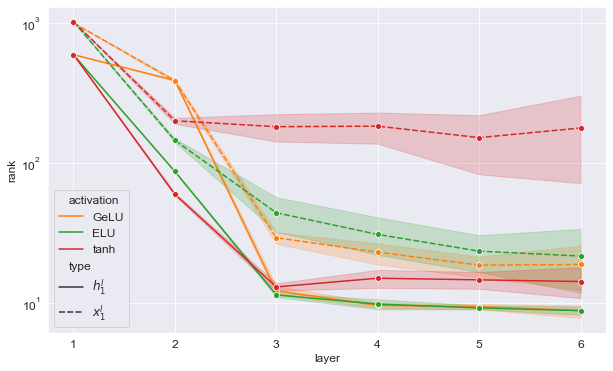

In [52]:
activations = ['GeLU', 'ELU', 'tanh']
df = ranks_df.loc[ranks_df.activation.isin(activations)]
plt.figure(figsize=FIGSIZE)

palette = sns.color_palette()[1:len(activations) + 1]
g = sns.lineplot(x="layer", y="rank", hue="activation", style='type',  data=df, marker='o', palette=palette)

g.set(yscale='log')

plt.show()

#fig_path = os.path.join(fig_dir, '{}_loss.png'.format(MODEL_NAME))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)